# Ballistic Motion

In [1]:
import numpy as np # for building and manipulating matrices
from matplotlib import pyplot as plt # for graphics

# for figure interactivity
%matplotlib notebook 
# good resolution retina graphics
%config InlineBackend.figure_format='retina' 

# The Setup

YouTube is littered with fake videos of purportedly amazing basketball shots. The code below analyzes the  trajectory of ballistic or projectile motion in a video to determine if it is real or not. Ballistic motion occurs when the only significant force on an object is gravity (i.e. it accelerates down to the ground).

In [2]:
from ipywidgets import Video
video = Video.from_file('ball.mp4')
video

Video(value=b'\x00\x00\x00\x1cftypmp42\x00\x00\x00\x01mp41mp42isom\x00\x00\x00\x08wide\x00\x02\xfa\x1dmdat\x00…

First we must extract the spatial coordinates (x, y) using mouse clicks on the center of the ball on each frame. Let's simplify this process by building a composite image that shows the ball's movement across the frames all in one picture. I will use a step to avoid using all video frames in the zip file.

In [3]:
# initialization
STEP = 4
TFRAMES = 100    
nframes = TFRAMES//STEP
coords = np.zeros((0,2))

Load the desired frames into a `frames` array which is a 4-dimensional matrix of dimensions height $\times$ width $\times$ num channels $\times$ num frames

In [4]:
# load frames into matrix
height, width, channels = plt.imread('vidframes/frame1.jpg').shape
frames = np.empty((height,width,channels,nframes),dtype = np.uint8) # set up empty frames matrix

# loop through frames
for i in range(nframes):
    frame = plt.imread('vidframes/frame%d.jpg' % (i * STEP + 1))   # read in frames
    frames[:,:,:,i] = frame # store frame

Now let's build the composite image. Since the the ball is a dark color relative to the rest of the image, we can compile its motion across the frames by building a new image that features the darkest (minimum) pixel values from each image.

In [5]:
composite = np.amin(frames, axis=3)

Run the cell below to check if your composite image was created correctly. The image should contain the ballistic motion of the ball at 25 moments.

<IPython.core.display.Javascript object>


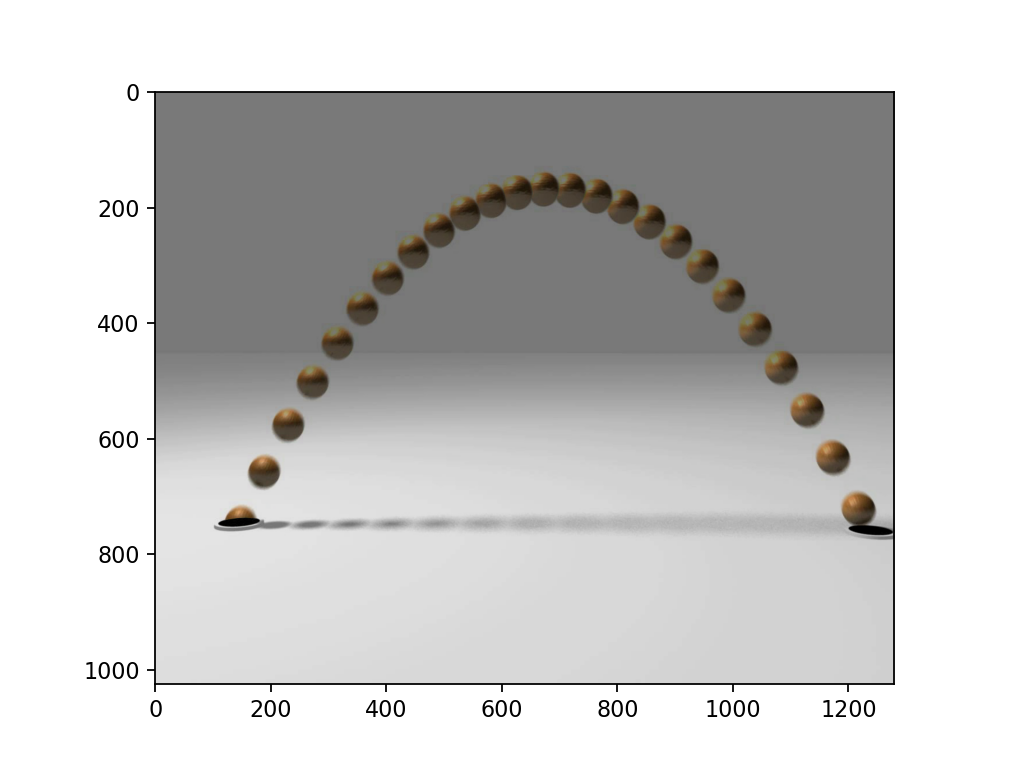

In [6]:
fig = plt.figure()
plt.imshow(composite)
plt.show()

Selects coordinates by clicking on the center of some of the balls in the composite image

In [7]:
# function handling button clicks
def onclick(event):
    global coords
    coords = np.vstack((coords, [event.xdata, event.ydata]))
    plt.title(f"Composite Image ({coords.shape[0]} points clicked)")
    plt.scatter([event.xdata], [event.ydata], c='r', s=20)

<IPython.core.display.Javascript object>


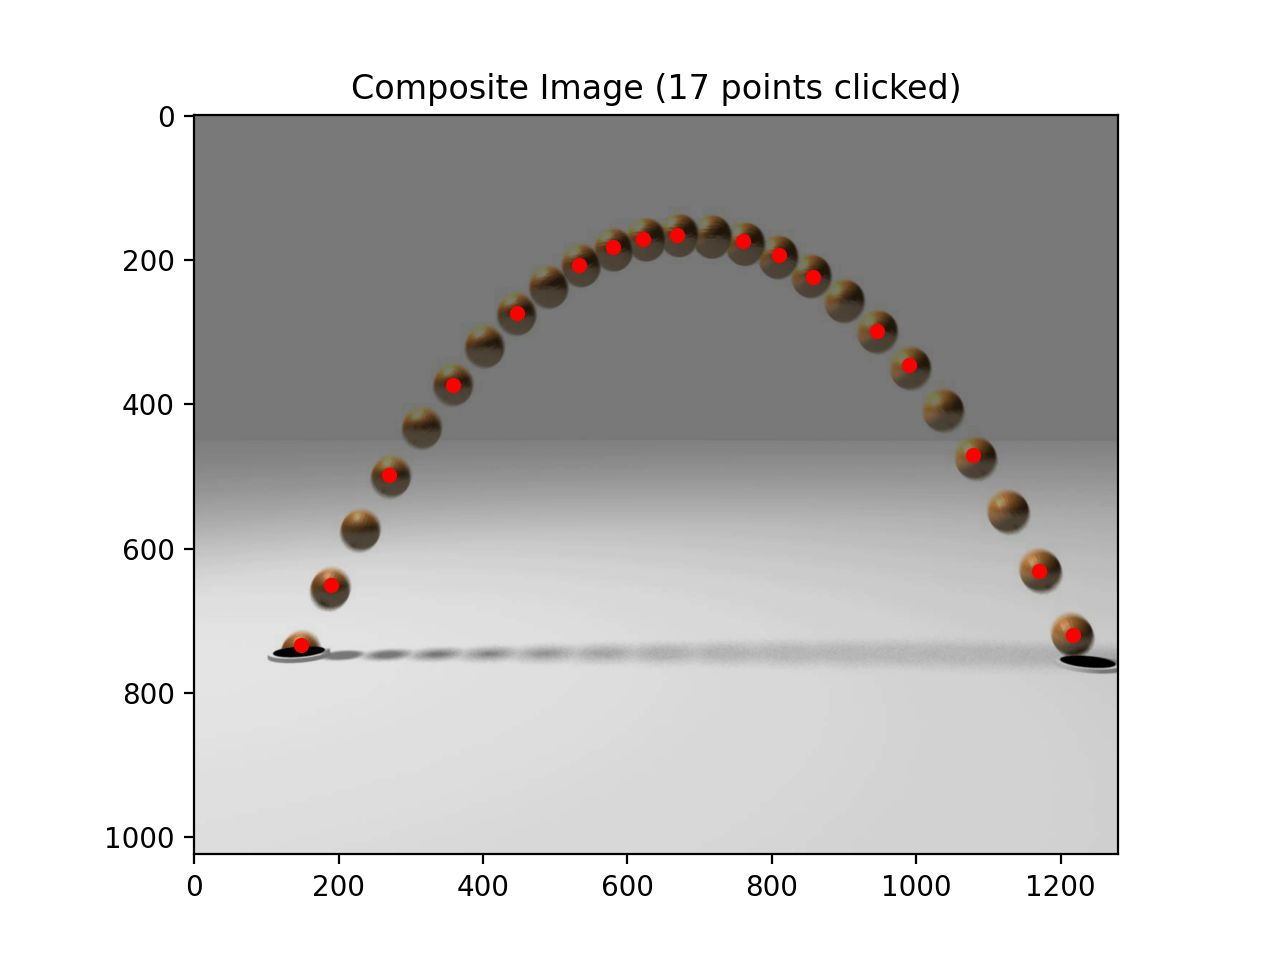

In [8]:
# load your composite image and select ball coordinates
fig = plt.figure()
plt.imshow(composite)
cid = fig.canvas.mpl_connect('button_press_event', onclick) # for handling button click
plt.title("Composite Image (Click ball centers)")
plt.show()

In [9]:
# print coords and dimensions
print("Coords is a (%d,%d) matrix with elements:" % (coords.shape[0], coords.shape[1]))
print(coords)

Coords is a (17,2) matrix with elements:
[[ 147.8982684   732.75108225]
 [ 189.45670996  649.63419913]
 [ 269.8030303   497.25324675]
 [ 358.46103896  372.57792208]
 [ 447.11904762  272.83766234]
 [ 533.00649351  206.34415584]
 [ 621.66450216  170.32683983]
 [ 580.10606061  181.40909091]
 [ 668.76406926  164.78571429]
 [ 760.19264069  173.0974026 ]
 [ 810.06277056  192.49134199]
 [ 857.16233766  222.96753247]
 [ 945.82034632  297.77272727]
 [ 990.14935065  344.87229437]
 [1078.80735931  469.54761905]
 [1170.23593074  630.24025974]
 [1217.33549784  718.8982684 ]]


Save the coords matrix to a file.

In [10]:
np.savetxt('coords.txt', coords)

# The estimation

In [11]:
coords = np.loadtxt('coords.txt')
# print coords and dimensions
print("Coords is a (%d,%d) matrix with elements:" % (coords.shape[0], coords.shape[1]))
print(coords)

x = coords[:,0]
y = coords[:,1]

Coords is a (17,2) matrix with elements:
[[ 147.8982684   732.75108225]
 [ 189.45670996  649.63419913]
 [ 269.8030303   497.25324675]
 [ 358.46103896  372.57792208]
 [ 447.11904762  272.83766234]
 [ 533.00649351  206.34415584]
 [ 621.66450216  170.32683983]
 [ 580.10606061  181.40909091]
 [ 668.76406926  164.78571429]
 [ 760.19264069  173.0974026 ]
 [ 810.06277056  192.49134199]
 [ 857.16233766  222.96753247]
 [ 945.82034632  297.77272727]
 [ 990.14935065  344.87229437]
 [1078.80735931  469.54761905]
 [1170.23593074  630.24025974]
 [1217.33549784  718.8982684 ]]


The answer may seem obvious here but fit the points to each of the following equations.
1. Line: $y = ax + b$
2. Parabola: $y = ax^{2} +bx+c$
3. Parabola with no first-order term: $y = ax^{2} + b$
4. Sinusoid: $y = a\sin(\frac{1}{335.5}x−9.9)+b$

I use Mean Squared Error to determine which of these fits is the best

In [12]:
# least squares estimator for line

# add column of ones for the intercept
A = np.column_stack((x, np.ones_like(x)))
# solve normal equation
beta = np.linalg.solve(A.T@A, A.T@y)
a_line, b_line = beta[0], beta[1]

In [13]:
# least squares estimator for parabola

# Add x^2 column and column of ones for the intercept
A = np.column_stack((x**2, x, np.ones_like(x)))
# Solve normal equation
beta = np.linalg.solve(A.T@A, A.T@y)
a_parabola, b_parabola, c_parabola = beta[0], beta[1], beta[2]

In [14]:
# least squares estimator for parabola with no first order term

# Add x^2 column and column of ones for the intercept, no x column
A = np.column_stack((x**2, np.ones_like(x)))
# Solve normal equation
beta = np.linalg.solve(A.T@A, A.T@y)
a_parabola_no_first_order, b_parabola_no_first_order= beta[0], beta[1]

In [15]:
# least squares estimator for sinusoid

# Add x^2 column and column of ones for the intercept, no x column
A = np.column_stack((np.sin((x/335.5)-9.9), np.ones_like(x)))
# Solve normal equation
beta = np.linalg.solve(A.T@A, A.T@y)
a_sinusoid, b_sinusoid= beta[0], beta[1]

In [17]:
#### initialization
equation_names = ['line','parabola', 'parabola w/ no first-order term', 'sinusoid']
min_index = 0              # min_index stores the index of the equation that produces the minimum error
plotX = np.empty((len(equation_names)), dtype=np.ndarray)
plotY = np.empty((len(equation_names)), dtype=np.ndarray)

#### Your tasks: 
#### (1) calculate the least-squares error for each model and PRINT them; 

ssr = np.zeros(4)

# Line ls error
y_pred_line = a_line * x + b_line
residuals_line = y - y_pred_line
ssr_line = np.mean(residuals_line**2)
print('The MSE of the line is ', ssr_line)
ssr[0] = ssr_line

plotX[0]= x
plotY[0]= y_pred_line

# Parabola ls error
y_pred_parabola = a_parabola * x**2 + b_parabola * x + c_parabola
residuals_parabola = y - y_pred_parabola
ssr_parabola = np.mean(residuals_parabola**2)
print('The MSE of the parabola is ', ssr_parabola)
ssr[1] = ssr_parabola

plotX[1]= x
plotY[1]= y_pred_parabola

# Parabola no first order term ls error
y_pred_parabola_no_first_order = a_parabola_no_first_order * x**2 + b_parabola_no_first_order
residuals_parabola_no_first_order = y - y_pred_parabola_no_first_order
ssr_parabola_no_first_order = np.mean(residuals_parabola_no_first_order**2)
print('The MSE of the parabola with no first order term is ', ssr_parabola_no_first_order)
ssr[2] = ssr_parabola_no_first_order

plotX[2]= x
plotY[2]= y_pred_parabola_no_first_order

# Sinusoid ls error
y_pred_sinusoid = a_sinusoid * np.sin((x/335.5)-9.9) + b_sinusoid
residuals_sinusoid = y - y_pred_sinusoid
ssr_sinusoid = np.mean(residuals_sinusoid**2)
print('The MSE of the sinusoid is ', ssr_sinusoid)
ssr[3] = ssr_sinusoid

plotX[3]= x
plotY[3]= y_pred_sinusoid

#### (2) select the one with the minimum error and set the index in min_index.
min_index = np.argmin(ssr)

# Print the best model based on lowest mean squared error.
print('The best model is equation ' + str(equation_names[min_index]))


The MSE of the line is  39760.55443999207
The MSE of the parabola is  4.4147507020681545
The MSE of the parabola with no first order term is  38428.750616688696
The MSE of the sinusoid is  144.00122174026524
The best model is equation parabola


<IPython.core.display.Javascript object>


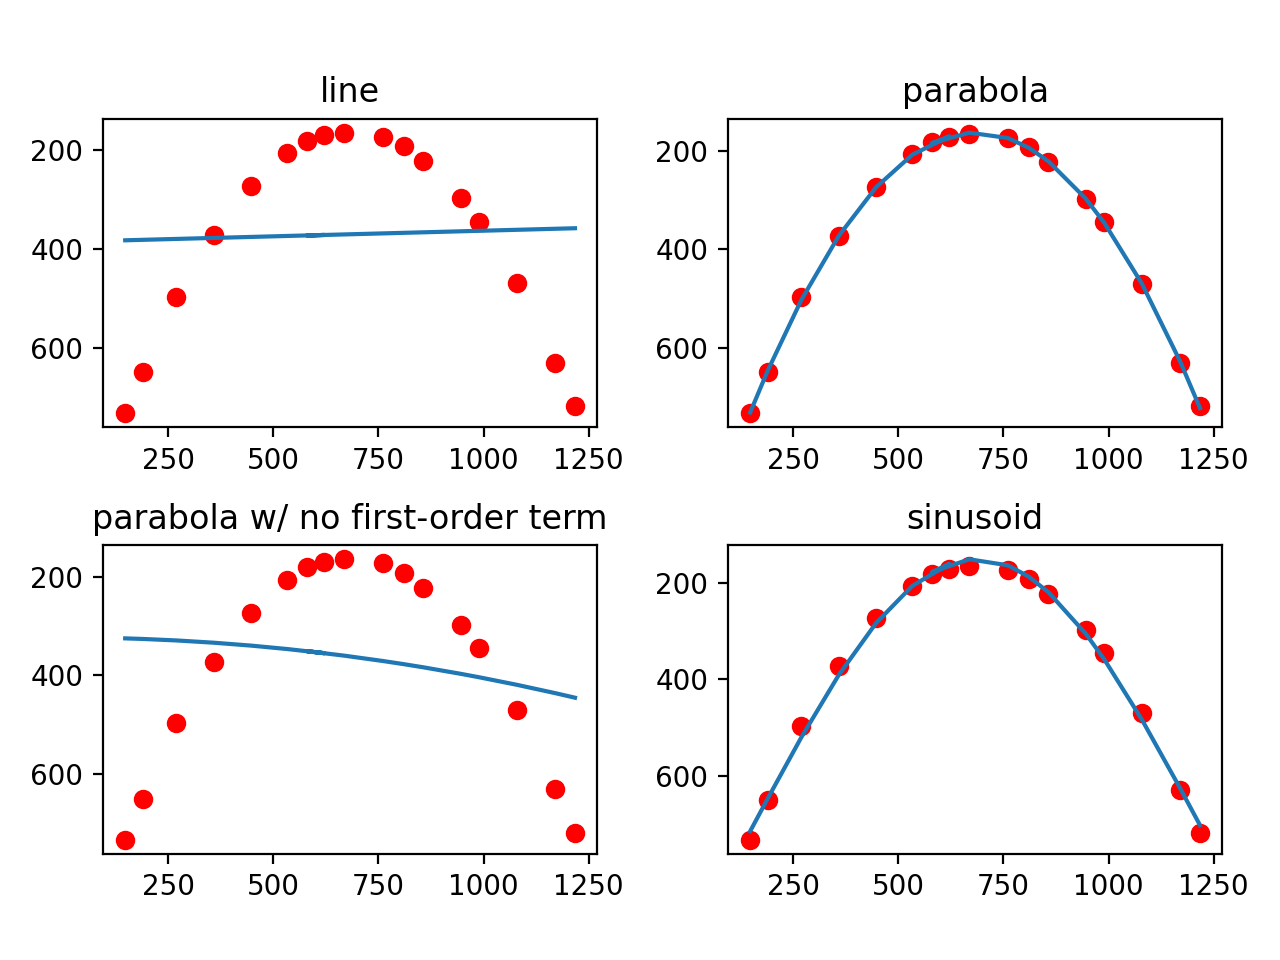

In [18]:
# display: Plot all equation models against your coordinates
fig, axs = plt.subplots(2,2)
f = 0  #equation index
for row in range(2):
    for col in range(2):
        #### Your tasks: 
        #### (1) draw the curve for each model;
        #### (2) draw the data points for each model;
        #### (3) reverse the y axis to follow the bottom-left-corner style;
        #### (4) specify the title of the plot to the equation's name.
        
              # Draw the curve for each model
        axs[row, col].plot(plotX[f], plotY[f], label=equation_names[f])

        # Draw the data points for each model
        axs[row, col].scatter(x, y, color='red')

        # Reverse the y-axis
        axs[row, col].invert_yaxis()

        # Specify the title of the plot to the equation's name
        axs[row, col].set_title(equation_names[f])
        f += 1
        
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

### Verify Solution

<IPython.core.display.Javascript object>


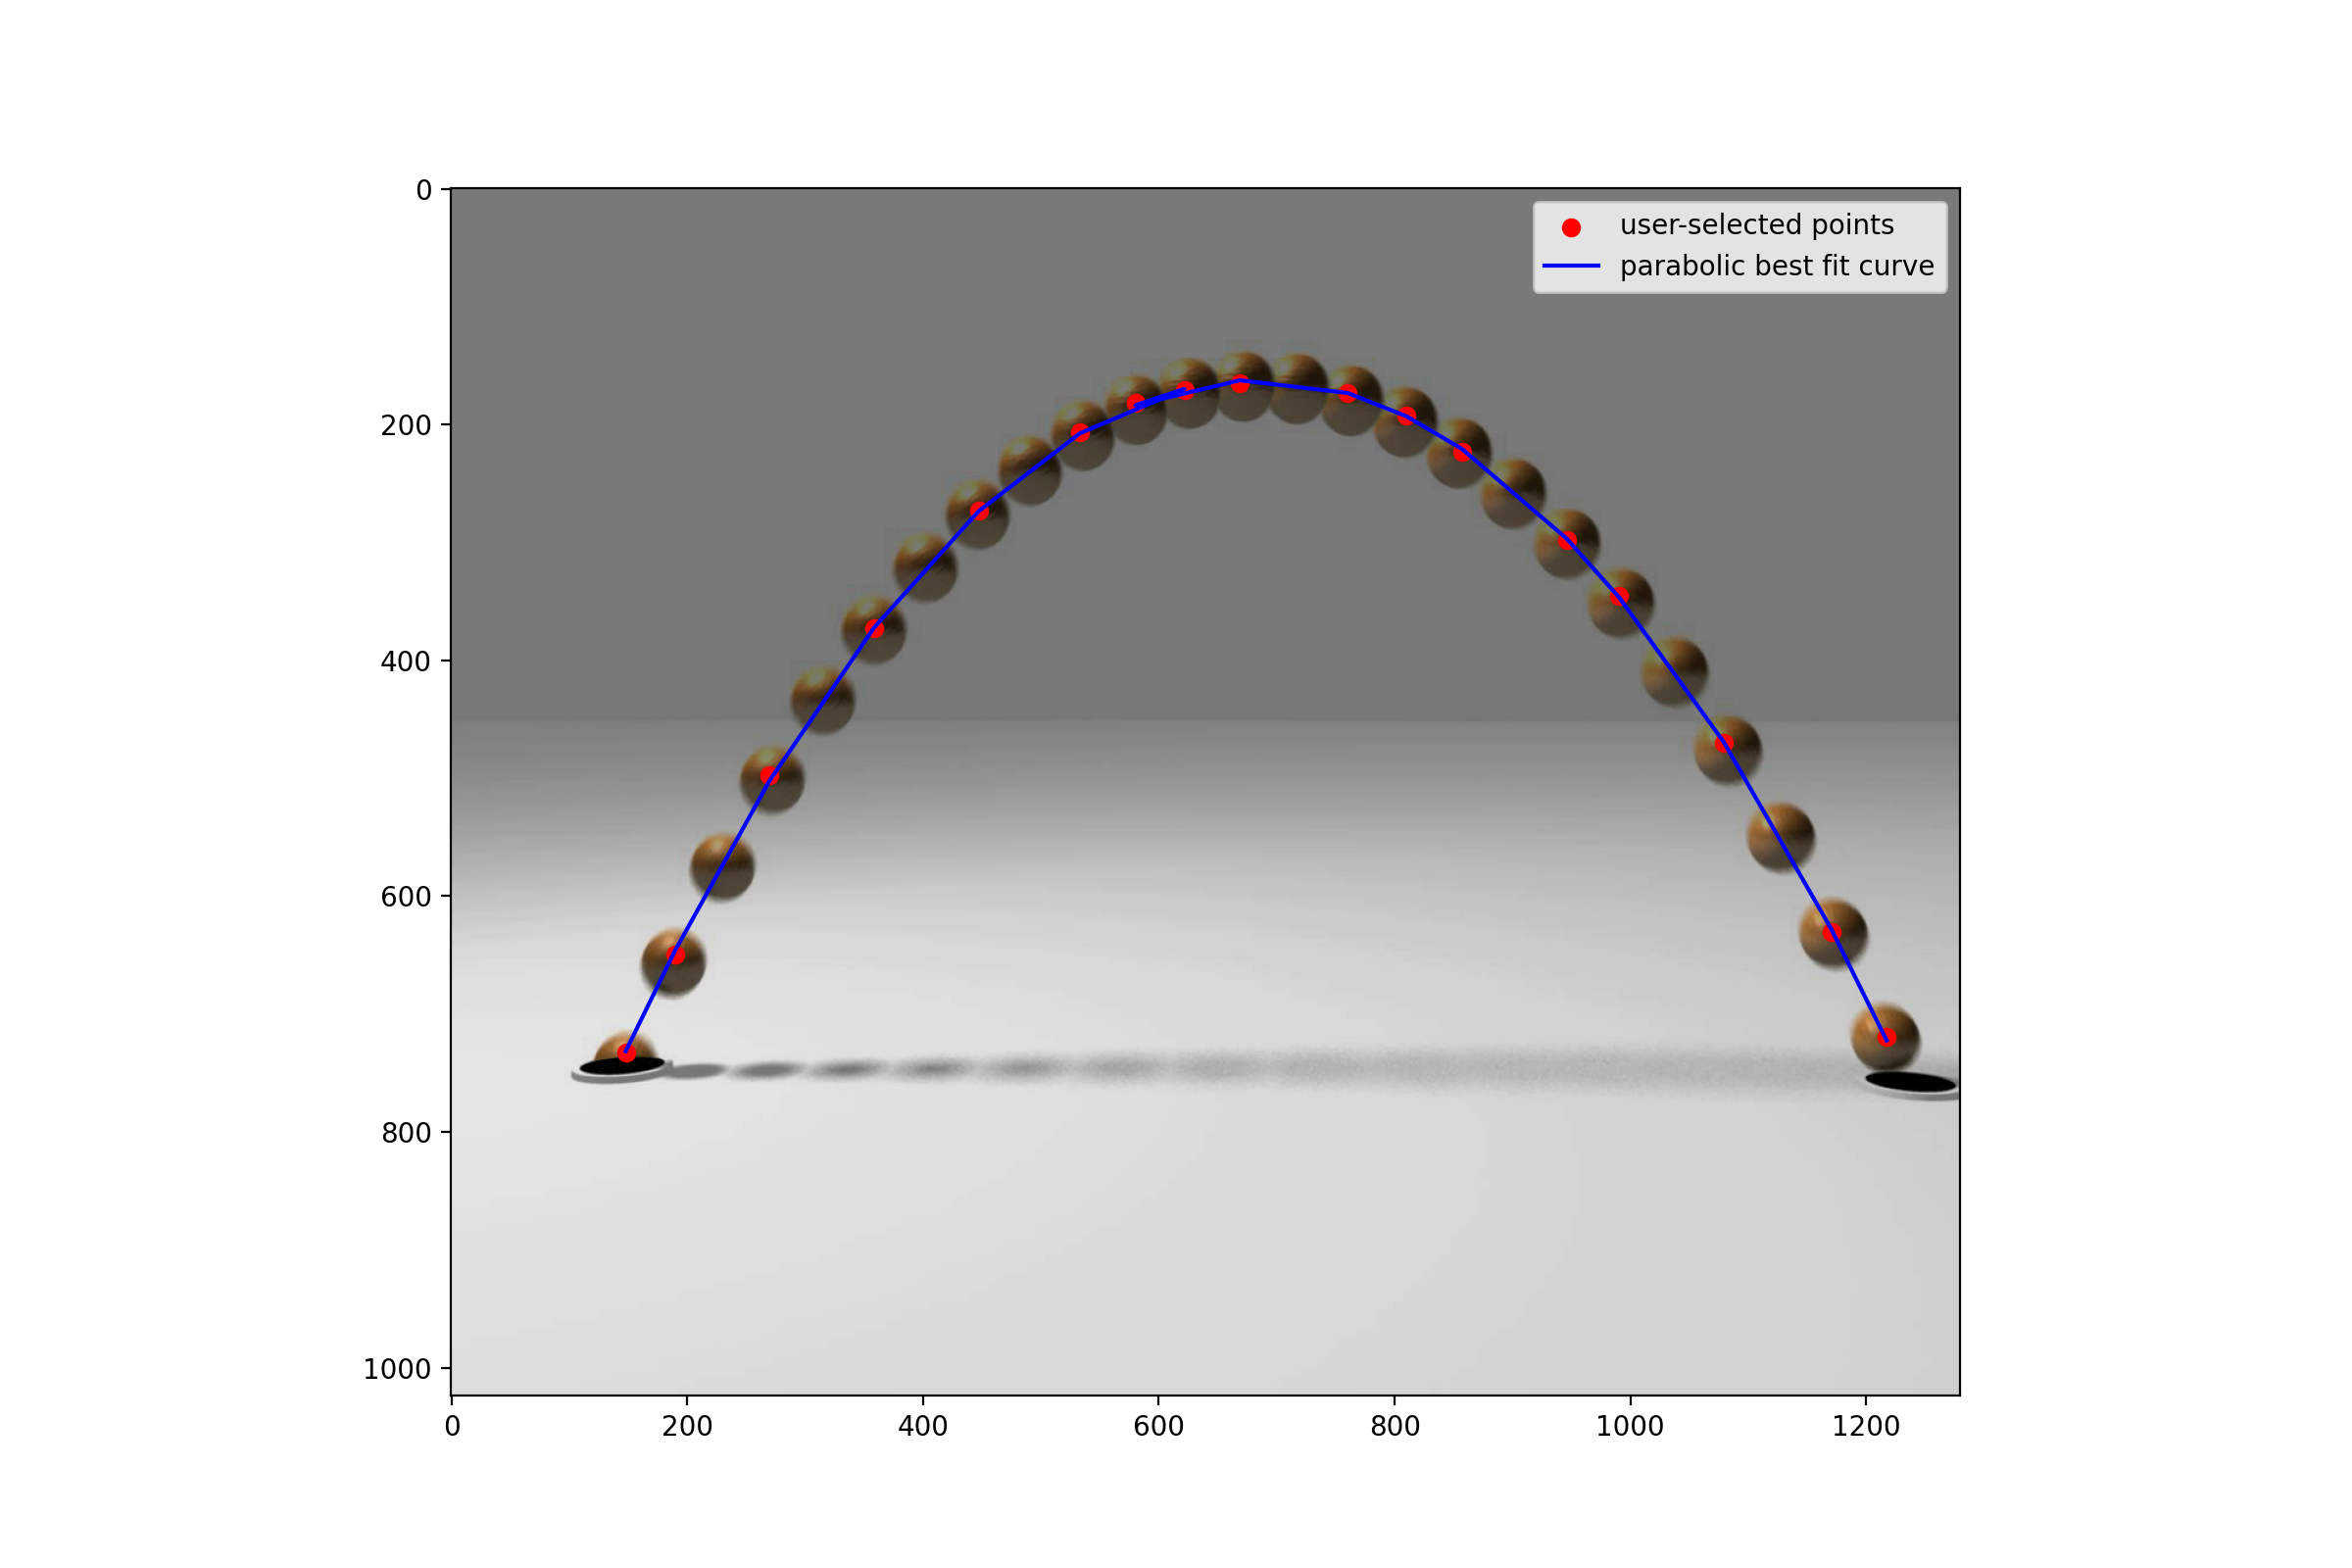

In [19]:
plt.figure()
plt.imshow(composite) # draw the composite image in the background

#### Your tasks:
#### (1) plot the user-selected points;
plt.scatter(x,y,color='red', label = 'user-selected points')
#### (2) plot the best-fit model curve.
plt.plot(plotX[1],plotY[1], color = 'blue', label = 'parabolic best fit curve')
plt.gcf().set_size_inches(12,8)
plt.legend()
plt.show()